In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon, normaltest
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
import pingouin as pg

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
#PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#V1
#PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']#V2
PHASE_COLORS = ['#c8abc9','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']#V3
PHASE_COLORS = ['k','k','k','k','k','k']

#dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
#act_directory = 'C:\\Users\insan\\Desktop\\Analysis_Cache_Aug23'

act_directory = '..\\..\\Data\\Analysis_Cache'
ops_directory = '..\\..\\Data\\Opsin_Cache'
beh_directory = '..\\..\\Data\\Behavioor'

current_version = 0 #June 23nd, 2023
current_version = 1 # July 21st 2023

stdfont = 14
stdyfrac = 0.06


In [20]:
#animals = np.concatenate((dualanimalnames,[]))
pre_opsin = ['AE_344','AE_346','AE_367']
pre_control = ['AE_350','AE_351','AE_359']

pre_steady_opsin = ['AE_368','AE_369','AE_389']
pre_steady_controls = ['AE_363','AE_395']#and 389

post_steady_opsin = ['AE_376','AE_379']#,'AE_399']
post_steady_controls = ['AE_391']

animals = np.concatenate([pre_opsin,pre_control,pre_steady_opsin,pre_steady_controls,post_steady_opsin,post_steady_controls])
print(animals)

['AE_344' 'AE_346' 'AE_367' 'AE_350' 'AE_351' 'AE_359' 'AE_368' 'AE_369'
 'AE_389' 'AE_363' 'AE_395' 'AE_376' 'AE_379' 'AE_391']


In [52]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\4thgr\OneDrive\Documents\TothSidleck2024\Notebooks\Opsin Pre\../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in scalar divide
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy shoul

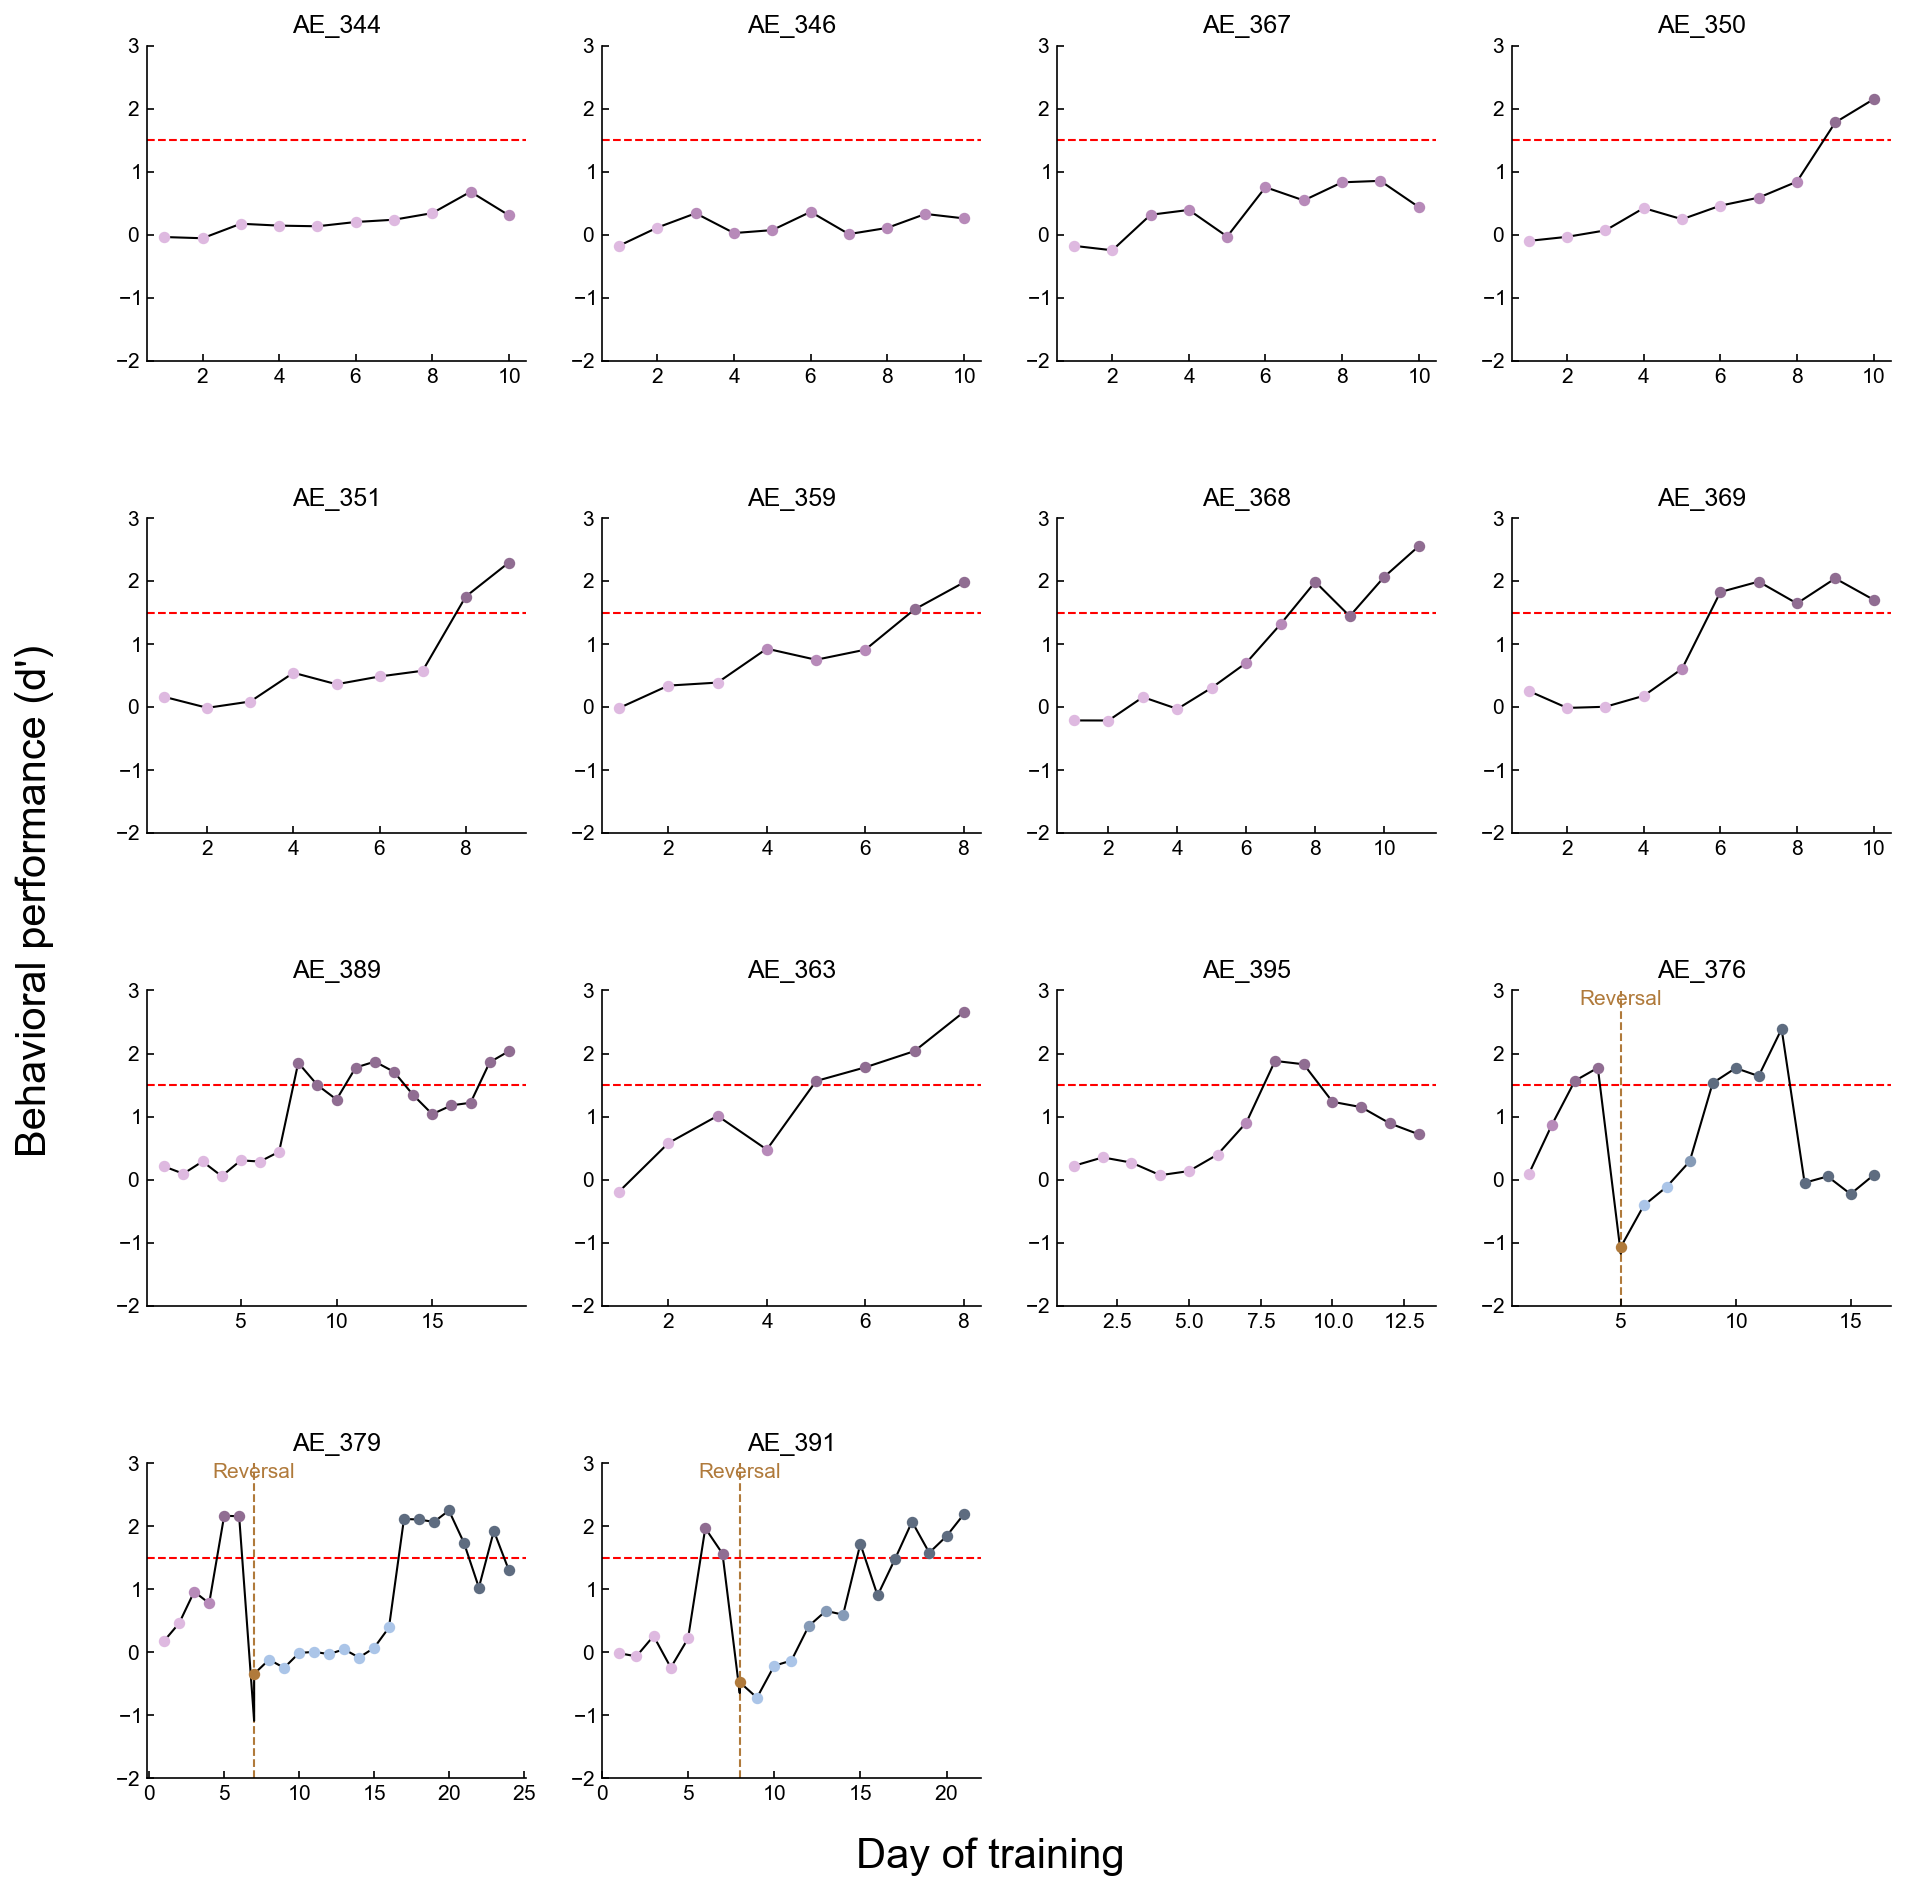

In [53]:
animalPhases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)
#plt.savefig(os.path.join('D:\\\\TempFigures','All ephys animals learning phases.pdf'),transparent=False,facecolor="white")

In [54]:
animal_list = []
day_list = []
dp_total_list = []
phase_list = []

# animallist = ['AE_344','AE_346','AE_367','AE_350','AE_351','AE_359']
animallist = animals
for animal in animallist:
    reversal = animalBehaviors[animal].reversal
    days = list(np.unique(list(animalBehaviors[animal].sessions.keys())))
    expert_days = np.concatenate(( animalPhases[animal].pre_expert_days,animalPhases[animal].post_expert_days,animalPhases[animal].second_expert_days ))
    dp_list,pc_list = ilep.getPCDPfromBehavior(animalBehaviors,animal,days,expert_days,exclude_first_switch=True)
    days = np.sort(days)

    for idx,day in enumerate(days):
        phase = 'N/A'
        if day in animalPhases[animal].pre_early_days:
            phase = 'pre early'
        elif day in animalPhases[animal].pre_late_days:
            phase = 'pre late'
        elif day in animalPhases[animal].pre_expert_days:
            phase = 'pre expert'
        elif day == reversal:
            phase = 'switch'
        elif day in animalPhases[animal].post_early_days:    
            phase = 'post early'
        elif day in animalPhases[animal].post_late_days:
            phase = 'post late'
        elif day in animalPhases[animal].post_expert_days:
            phase = 'post expert'

        if phase == 'N/A':
            continue
            #This hits only BS_40 day 17. Excluded due to animal's poor motivation
        
        animal_list.append(animal)
        day_list.append(day)
        dp_total_list.append(dp_list[idx])
        phase_list.append(phase)

In [55]:
df_dict = dict()
df_dict['animal'] = animal_list
df_dict['session'] = day_list
df_dict['d\''] = dp_total_list
df_dict['learning phase'] = phase_list
df = pd.DataFrame(df_dict)

In [56]:
df

,animal,session,d',learning phase
0,AE_344,1,-0.040102,pre early
1,AE_344,2,-0.059415,pre early
2,AE_344,3,0.170955,pre early
3,AE_344,4,0.140812,pre early
4,AE_344,5,0.130571,pre early
...,...,...,...,...
174,AE_391,17,1.469048,post expert
175,AE_391,18,2.068489,post expert
176,AE_391,19,1.574887,post expert
177,AE_391,20,1.838654,post expert


In [57]:
df.to_csv('..\\..\\Source Data Files\Pre Opto Learning Phases.csv')

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\4thgr\AppData\Local\Temp\ipykernel_20964\926620442.py:1: SyntaxWarning: invalid escape sequence '\P'
  df.to_csv('..\\..\\Source Data Files\Pre Opto Learning Phases.csv')


In [58]:
df = pd.read_csv('..\\..\\Source Data Files\Pre Opto Learning Phases.csv')

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\4thgr\AppData\Local\Temp\ipykernel_20964\470203826.py:1: SyntaxWarning: invalid escape sequence '\P'
  df = pd.read_csv('..\\..\\Source Data Files\Pre Opto Learning Phases.csv')


In [ ]:
reversal = np.nan

In [77]:
def animal_learning_curve_reconstructed(animal,cutoff=np.Inf):
    rev = animalBehaviors[animal].reversal
    max_day = len(animalBehaviors[animal].sessions)
    max_day = min(max_day,cutoff)
    print(rev)
    print(max_day)

    fig, ax = plt.subplots(figsize=(5,4.5))
    PLOTTING_PHASE_COLORS = PHASE_COLORS

    df_animal = df[df['animal'] == animal]
    df_animal = df_animal[df_animal['session']<=cutoff]
    days = df_animal['session']
    
    pre_early = df_animal['learning phase'] == 'pre early'
    pre_late = df_animal['learning phase'] == 'pre late'
    pre_expert = df_animal['learning phase'] == 'pre expert'
    switch = df_animal['learning phase'] == 'switch'
    post_early = df_animal['learning phase'] == 'post early'
    post_late = df_animal['learning phase'] == 'post late'
    post_expert = df_animal['learning phase'] == 'post expert'
    
    # reversal = days[switch]
    # expert_days = np.concatenate(( animalPhases[animal].pre_expert_days,animalPhases[animal].post_expert_days,animalPhases[animal].second_expert_days ))
    dp_list = df_animal['d\'']

    ax.plot(days,dp_list,color='k',lw=1)

    circle_size = 60

    #Pre Early
    # pre_early = np.isin(days,animalPhases[animal].pre_early_days)
    ax.scatter(days[pre_early],dp_list[pre_early],color=PLOTTING_PHASE_COLORS[0],s=circle_size,zorder=10,clip_on=False)

    #Pre Late
    # pre_late = np.isin(days,animalPhases[animal].pre_late_days)
    ax.scatter(days[pre_late],dp_list[pre_late],color=PLOTTING_PHASE_COLORS[1],s=circle_size,zorder=10,clip_on=False)

    #Pre Expert
    # pre_expert = np.isin(days,animalPhases[animal].pre_expert_days)
    ax.scatter(days[pre_expert],dp_list[pre_expert],color=PLOTTING_PHASE_COLORS[2],s=circle_size,zorder=10,clip_on=False)

    # #Post Early
    # # post_early = np.isin(days,animalPhases[animal].post_early_days)
    # ax.scatter(days[post_early],dp_list[post_early],color=PLOTTING_PHASE_COLORS[3],s=circle_size,zorder=10)

    # #Post Late
    # # post_late = np.isin(days,animalPhases[animal].post_late_days)
    # ax.scatter(days[post_late],dp_list[post_late],color=PLOTTING_PHASE_COLORS[4],s=circle_size,zorder=10)

    # #Post Expert
    # # post_expert = np.isin(days,animalPhases[animal].post_expert_days)
    # ax.scatter(days[post_expert],dp_list[post_expert],color=PLOTTING_PHASE_COLORS[5],s=circle_size,zorder=10)

    # #Switch
    # # switch = np.equal(days,animalBehaviors[animal].reversal)
    # ax.scatter(days[switch],dp_list[switch],color=SWITCH_COLOR,s=circle_size,zorder=10)
    ax.set_ylim([-1,3])
    ax.set_yticks([-1,0,1,2,3])

    ax.set_xlim([0,min(10,max_day)])
    ax.set_xticks(range(0,9))
    # for index, label in enumerate(ax.xaxis.get_ticklabels()):
    #     #labeledindex = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41]
    #     #labeledindex = [1,5,9,13,17,21,25,29,33,37,41]
    #     labeledindex = [1,5,10]
    #     if index not in labeledindex:
    #         label.set_visible(False)
            
    ax.tick_params(length=6)

    # size = 0.5
    # center = np.mean(ax.get_ylim())
    # ax.text(reversal,center,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center',rotation=90)
    # ax.plot([rev,rev],[ax.get_ylim()[0],center-size],color=SWITCH_COLOR,lw=1,linestyle='-')
    # ax.plot([rev,rev],[center+size,ax.get_ylim()[1]],color=SWITCH_COLOR,lw=1,linestyle='-')

    ax.axhline(1.5,c='r',linestyle='--',lw=1,zorder=-20)
    print(reversal)
    # ax.text(1.3,-0.3,'Early',color=PLOTTING_PHASE_COLORS[0])
    # ax.text(7,0.8,'Late',color=PLOTTING_PHASE_COLORS[1])
    # ax.text(4.6,2.5,'Expert',color=PLOTTING_PHASE_COLORS[2])
    # ax.text(8.6,-0.7,'Early',color=PLOTTING_PHASE_COLORS[3])
    # ax.text(12.5,-0.1,'Late',color=PLOTTING_PHASE_COLORS[4])
    # ax.text(14.2,2.5,'Expert',color=PLOTTING_PHASE_COLORS[5])

    ax.set_ylabel("Behavioral performance (d') ")
    ax.set_xlabel('Sessions')
    ax.set_axisbelow(False)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    #These must be changed at the end. brokenaxes recalculates ticks for several calls
    ax.set_xticks(range(0,max_day+1))
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(stdfont)
    for item in (ax.get_xticklabels()):
        item.set_fontsize(stdfont*0.9)
        pass
    
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\DS_19.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\DS_15.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\BS_40.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\BS_108.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Manuscript\\Learning'+animal+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')

inf
10
nan


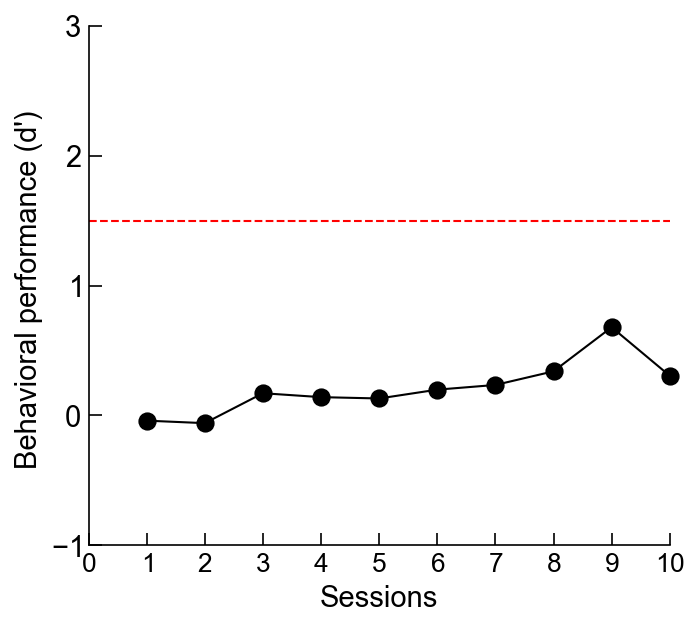

In [16]:
animal_learning_curve_reconstructed('AE_344')
artists = []
plt.savefig(os.path.join('C:\\Users\\4thgr\\Downloads\\AE_344.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

inf
10
nan


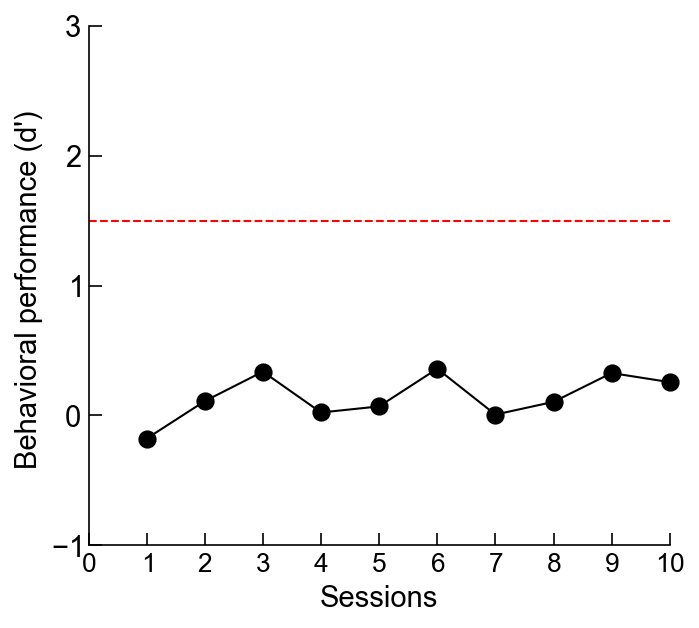

In [18]:
animal_learning_curve_reconstructed('AE_346')
artists = []
plt.savefig(os.path.join('C:\\Users\\4thgr\\Downloads\\AE_346.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

inf
10
nan


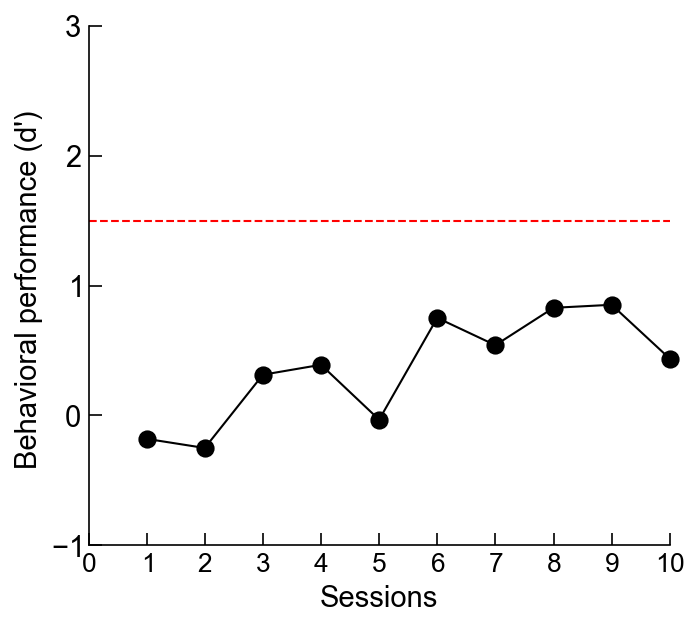

In [19]:
animal_learning_curve_reconstructed('AE_367')
artists = []
plt.savefig(os.path.join('C:\\Users\\4thgr\\Downloads\\AE_367.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

inf
10
nan


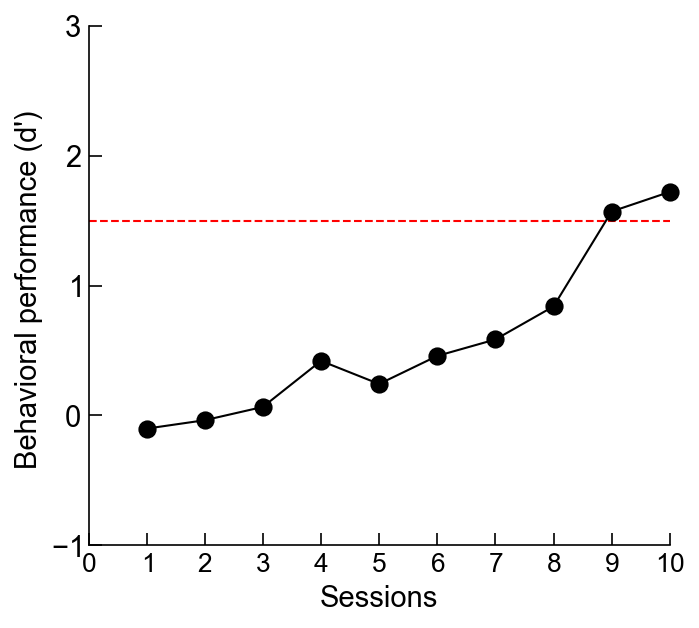

In [20]:
animal_learning_curve_reconstructed('AE_350')
artists = []
plt.savefig(os.path.join('C:\\Users\\4thgr\\Downloads\\AE_350.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

inf
9
nan


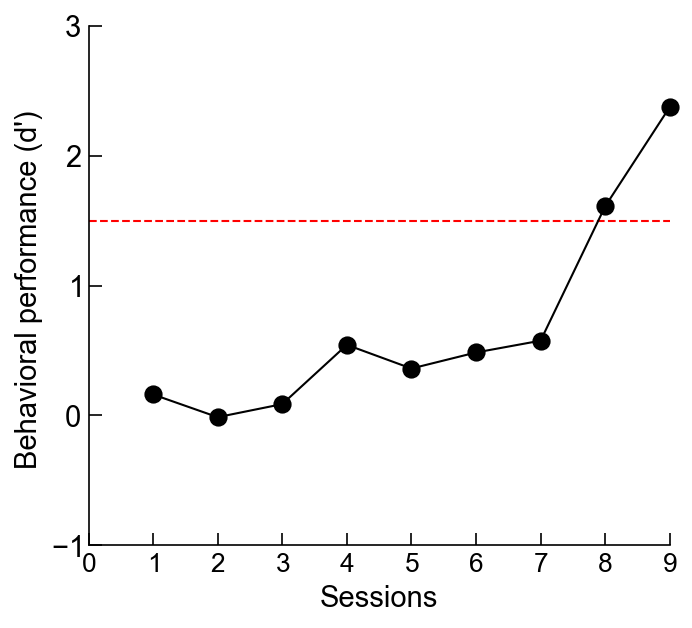

In [21]:
animal_learning_curve_reconstructed('AE_351')
artists = []
plt.savefig(os.path.join('C:\\Users\\4thgr\\Downloads\\AE_351.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

inf
8
nan


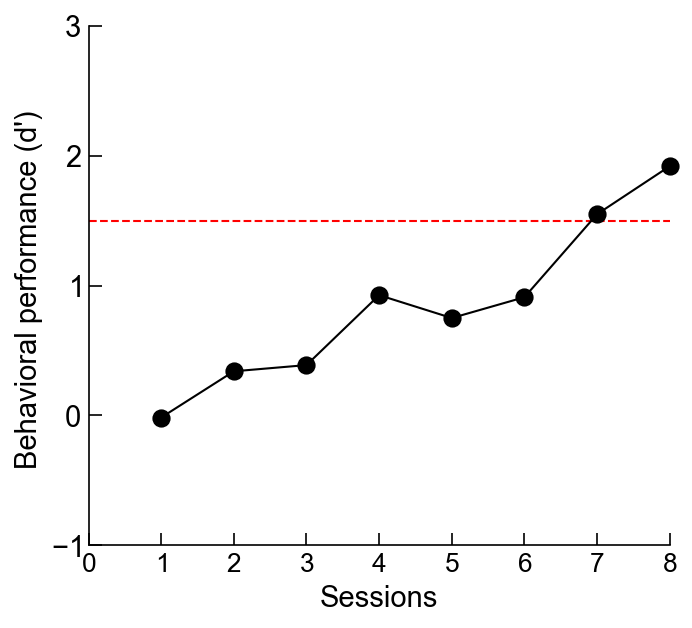

In [22]:
animal_learning_curve_reconstructed('AE_359')
artists = []
plt.savefig(os.path.join('C:\\Users\\4thgr\\Downloads\\AE_359.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

inf
8
nan


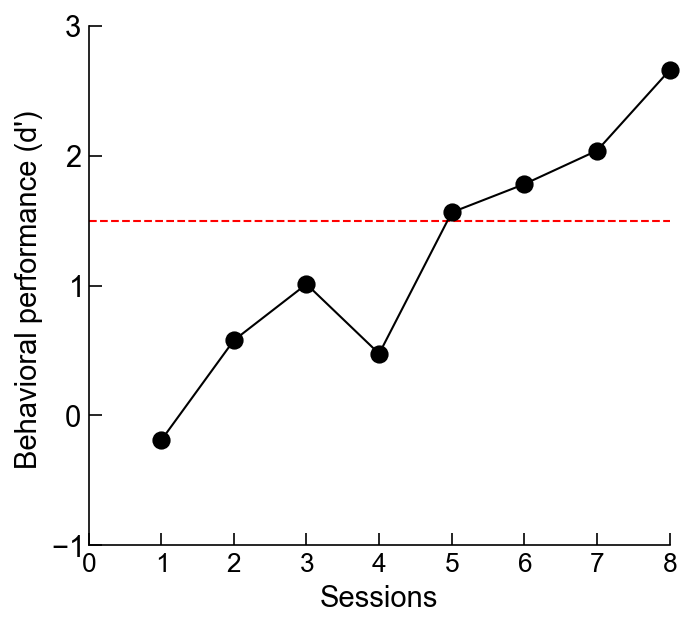

In [17]:
animal_learning_curve_reconstructed('AE_363')
artists = []
plt.savefig(os.path.join('C:\\Users\\4thgr\\Downloads\\AE_363.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

inf
13
nan


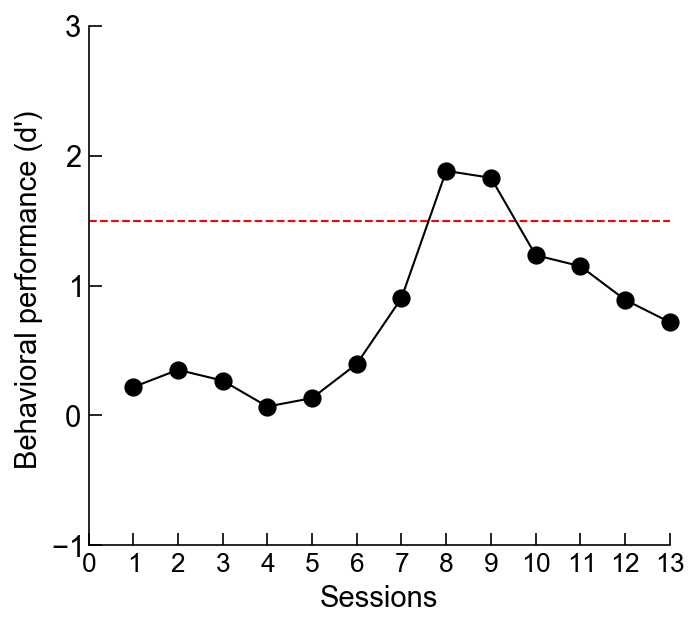

In [18]:
animal_learning_curve_reconstructed('AE_395')
artists = []
plt.savefig(os.path.join('C:\\Users\\4thgr\\Downloads\\AE_395.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

inf
19
8


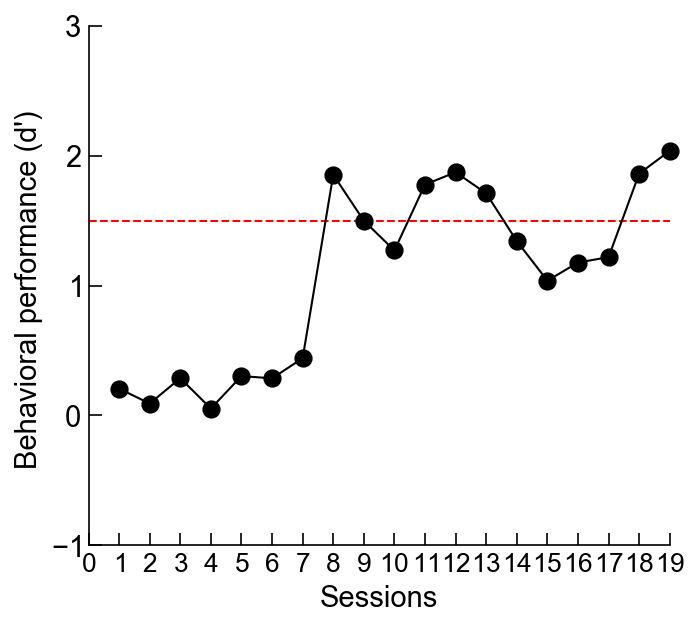

In [72]:
animal_learning_curve_reconstructed('AE_389')
artists = []
plt.savefig(os.path.join('C:\\Users\\4thgr\\Downloads\\AE_389.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

inf
13
8


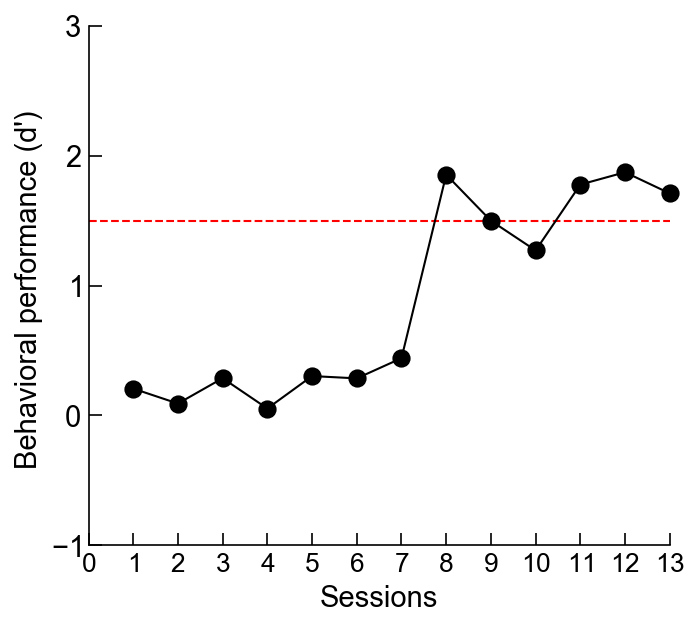

In [78]:
animal_learning_curve_reconstructed('AE_389',cutoff=13)
artists = []
plt.savefig(os.path.join('C:\\Users\\4thgr\\Downloads\\AE_389 CONTROL.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

inf
11
8


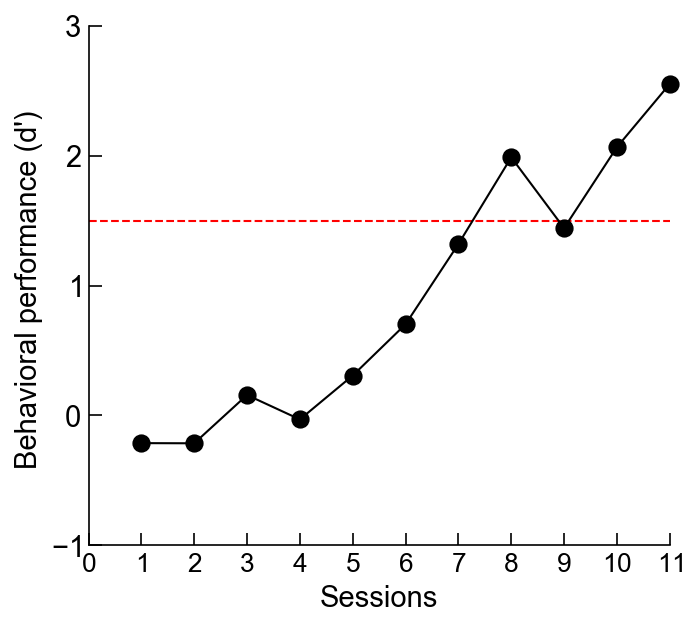

In [28]:
animal_learning_curve_reconstructed('AE_368')
artists = []
plt.savefig(os.path.join('C:\\Users\\4thgr\\Downloads\\AE_368.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

inf
10
8


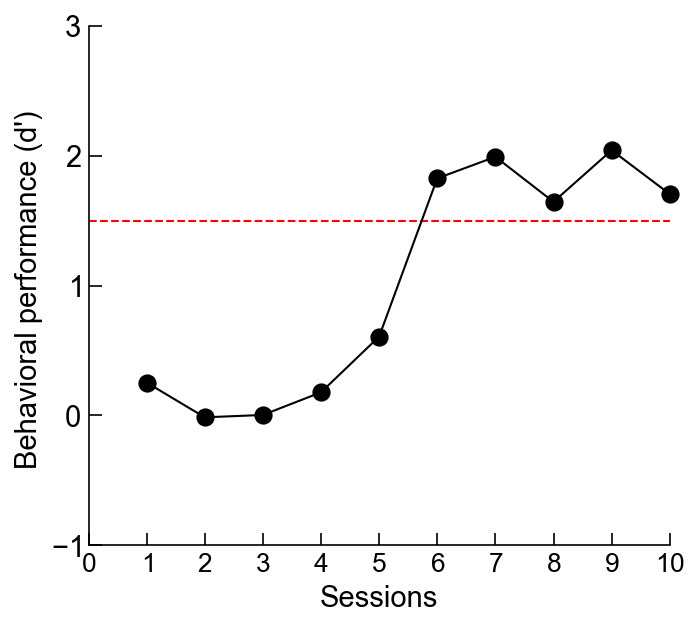

In [29]:
animal_learning_curve_reconstructed('AE_369')
artists = []
plt.savefig(os.path.join('C:\\Users\\4thgr\\Downloads\\AE_369.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [67]:
#Redefined for change to y axis

def animal_learning_curve_reconstructed(animal):
    rev = animalBehaviors[animal].reversal
    max_day = len(animalBehaviors[animal].sessions)
    print(rev)
    print(max_day)

    fig, ax = plt.subplots(figsize=(5,4.5))
    PLOTTING_PHASE_COLORS = PHASE_COLORS

    df_animal = df[df['animal'] == animal]
    days = df_animal['session']
    
    pre_early = df_animal['learning phase'] == 'pre early'
    pre_late = df_animal['learning phase'] == 'pre late'
    pre_expert = df_animal['learning phase'] == 'pre expert'
    switch = df_animal['learning phase'] == 'switch'
    post_early = df_animal['learning phase'] == 'post early'
    post_late = df_animal['learning phase'] == 'post late'
    post_expert = df_animal['learning phase'] == 'post expert'

    print(post_expert)
    
    # reversal = days[switch]
    # expert_days = np.concatenate(( animalPhases[animal].pre_expert_days,animalPhases[animal].post_expert_days,animalPhases[animal].second_expert_days ))
    dp_list = df_animal['d\'']

    ax.plot(days,dp_list,color='k',lw=1,clip_on=False)

    circle_size = 60

    #Pre Early
    # pre_early = np.isin(days,animalPhases[animal].pre_early_days)
    ax.scatter(days[pre_early],dp_list[pre_early],color=PLOTTING_PHASE_COLORS[0],s=circle_size,zorder=10,clip_on=False)

    #Pre Late
    # pre_late = np.isin(days,animalPhases[animal].pre_late_days)
    ax.scatter(days[pre_late],dp_list[pre_late],color=PLOTTING_PHASE_COLORS[1],s=circle_size,zorder=10,clip_on=False)

    #Pre Expert
    # pre_expert = np.isin(days,animalPhases[animal].pre_expert_days)
    ax.scatter(days[pre_expert],dp_list[pre_expert],color=PLOTTING_PHASE_COLORS[2],s=circle_size,zorder=10,clip_on=False)

    # #Post Early
    post_early = np.isin(days,animalPhases[animal].post_early_days)
    ax.scatter(days[post_early],dp_list[post_early],color=PLOTTING_PHASE_COLORS[3],s=circle_size,zorder=10,clip_on=False)

    # #Post Late
    post_late = np.isin(days,animalPhases[animal].post_late_days)
    ax.scatter(days[post_late],dp_list[post_late],color=PLOTTING_PHASE_COLORS[4],s=circle_size,zorder=10,clip_on=False)

    # #Post Expert
    post_expert = np.isin(days,animalPhases[animal].post_expert_days)
    ax.scatter(days[post_expert],dp_list[post_expert],color=PLOTTING_PHASE_COLORS[5],s=circle_size,zorder=10,clip_on=False)

    # #Switch
    switch = np.equal(days,animalBehaviors[animal].reversal)
    ax.scatter(days[switch],dp_list[switch],color='k',s=circle_size,zorder=10,clip_on=False)
    ax.set_ylim([-2,3])
    ax.set_yticks([-2,-1,0,1,2,3])

    ax.set_xlim([0,min(10,max_day)])
    ax.set_xticks(range(0,9))
    # for index, label in enumerate(ax.xaxis.get_ticklabels()):
    #     #labeledindex = [1,3,5,7,9,11,13,15,17,19,21,23,25,27,29,31,33,35,37,39,41]
    #     #labeledindex = [1,5,9,13,17,21,25,29,33,37,41]
    #     labeledindex = [1,5,10]
    #     if index not in labeledindex:
    #         label.set_visible(False)
            
    ax.tick_params(length=6)

    # size = 0.5
    # center = np.mean(ax.get_ylim())
    # ax.text(reversal,center,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center',rotation=90)
    # ax.plot([rev,rev],[ax.get_ylim()[0],center-size],color=SWITCH_COLOR,lw=1,linestyle='-')
    # ax.plot([rev,rev],[center+size,ax.get_ylim()[1]],color=SWITCH_COLOR,lw=1,linestyle='-')

    ax.axhline(1.5,c='r',linestyle='--',lw=1,zorder=-20)
    print(reversal)
    # ax.text(1.3,-0.3,'Early',color=PLOTTING_PHASE_COLORS[0])
    # ax.text(7,0.8,'Late',color=PLOTTING_PHASE_COLORS[1])
    # ax.text(4.6,2.5,'Expert',color=PLOTTING_PHASE_COLORS[2])
    # ax.text(8.6,-0.7,'Early',color=PLOTTING_PHASE_COLORS[3])
    # ax.text(12.5,-0.1,'Late',color=PLOTTING_PHASE_COLORS[4])
    # ax.text(14.2,2.5,'Expert',color=PLOTTING_PHASE_COLORS[5])

    ax.set_ylabel("Behavioral performance (d') ")
    ax.set_xlabel('Sessions')
    ax.set_axisbelow(False)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    #These must be changed at the end. brokenaxes recalculates ticks for several calls
    ax.set_xticks(range(0,max_day+2,2))
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(stdfont)
    for item in (ax.get_xticklabels()):
        item.set_fontsize(stdfont*0.9)
        pass
    
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\DS_19.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\DS_15.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\BS_40.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\BS_108.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')
    #fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Manuscript\\Learning'+animal+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')

5
16
118    False
119    False
120    False
121    False
122    False
123    False
124    False
125    False
126     True
127     True
128     True
129     True
130     True
131     True
132     True
133     True
Name: learning phase, dtype: bool
8


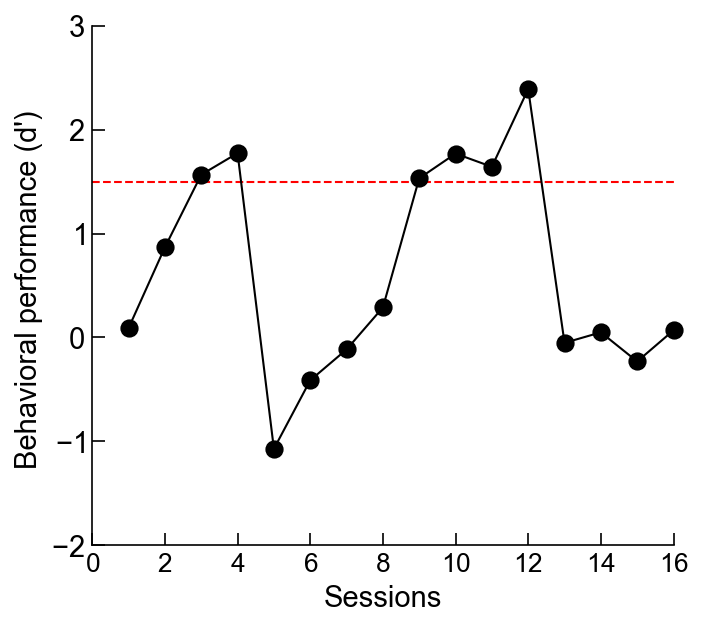

In [68]:
animal_learning_curve_reconstructed('AE_376')
artists = []
plt.savefig(os.path.join('C:\\Users\\4thgr\\Downloads\\AE_376.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

7
24
134    False
135    False
136    False
137    False
138    False
139    False
140    False
141    False
142    False
143    False
144    False
145    False
146    False
147    False
148    False
149    False
150     True
151     True
152     True
153     True
154     True
155     True
156     True
157     True
Name: learning phase, dtype: bool
8


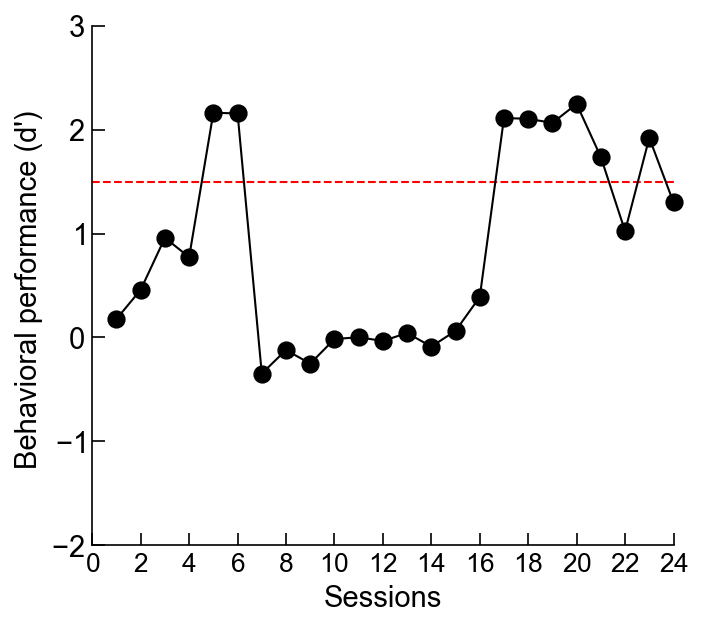

In [69]:
animal_learning_curve_reconstructed('AE_379')
artists = []
plt.savefig(os.path.join('C:\\Users\\4thgr\\Downloads\\AE_379.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

8
21
158    False
159    False
160    False
161    False
162    False
163    False
164    False
165    False
166    False
167    False
168    False
169    False
170    False
171    False
172     True
173     True
174     True
175     True
176     True
177     True
178     True
Name: learning phase, dtype: bool
8


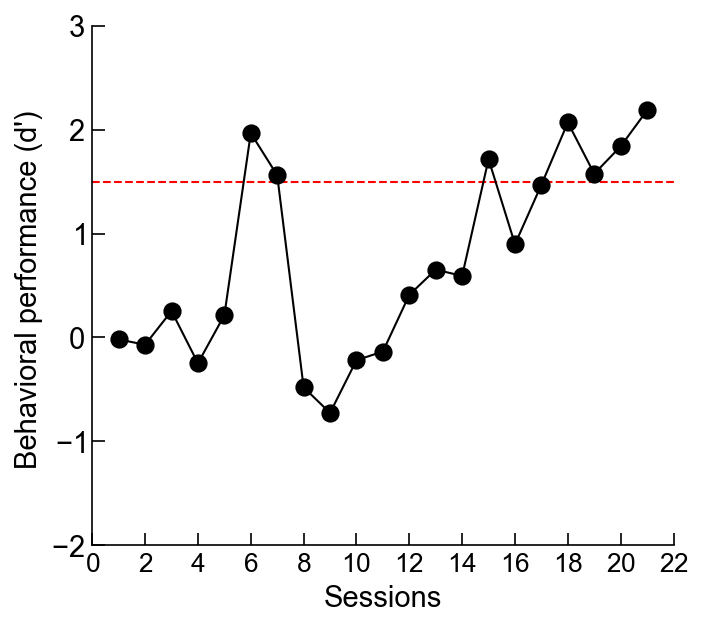

In [70]:
animal_learning_curve_reconstructed('AE_391')
artists = []
plt.savefig(os.path.join('C:\\Users\\4thgr\\Downloads\\AE_391.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')